In [256]:
# Imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
from functools import reduce

import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils import load_dataset
from visualization import visualize_comparison, visualize_frames
from sh_kinematics import shadow_hand_fk

sns.set_style("darkgrid")

root = Path() / "saves"
cp_path = Path().resolve().parents[1] / "ContactPose"
joint_names = ["wr2", "wr1", "th5", "th4", "th3", "th2", "th1", "ff4", "ff3", "ff2", "mf4", "mf3", "mf2", "rf4", "rf3", "rf2",
               "lf5", "lf4", "lf3", "lf2"]

In [162]:
# Load datasets
with open(root / "joint_verification.json", "r") as f:
    joint_verification = json.load(f)
with open(root / "sh_joints.json", "r") as f:
    sh_joints = json.load(f)
sh_joints = sorted(sh_joints, key=lambda x: x[2])
hands = load_dataset(cp_path)

In [163]:
def load_pd_df(sh_joints, joint_verification):
    COUPLING_CONST = 0.87577639751
    sh_joints = sorted(sh_joints, key=lambda x: x[2])
    # ff1, mf1, rf1, lf1 are coupled
    df = pd.DataFrame(np.array([j[0][3:] for j in sh_joints]), columns=joint_names)
    df["error"] = np.array([j[1] for j in sh_joints])
    df["valid"] = np.array([joint_verification[str(idx)] for idx in range(len(joint_verification))])
    return df

In [164]:
df = load_pd_df(sh_joints, joint_verification)

In [165]:
valid_df = df[df["valid"]]
invalid_df = df[df["valid"] == False]

## Data analysis

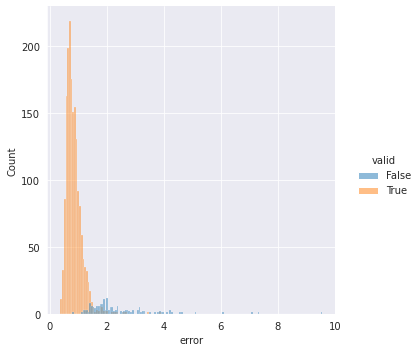

In [166]:
sns.displot(df, x="error", hue="valid")

## PCA analyis

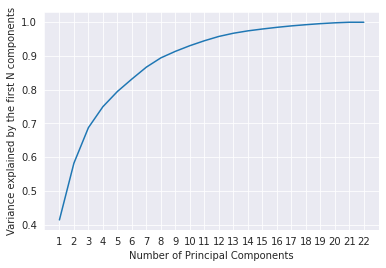

In [230]:
pca = PCA()
pca.fit(valid_df)  # SKLearn centers the data before applying the SVD
svals = pca.singular_values_
expl_var = pca.explained_variance_ratio_
sns.lineplot(x=np.arange(1,len(expl_var)+1),y=np.cumsum(expl_var))
plt.xlabel("Number of Principal Components")
plt.xticks(np.arange(1,len(expl_var)+1))
plt.ylabel("Variance explained by the first N components")
plt.show()

In [240]:
eigengrasps = {idx:   {"joints": pca.components_[idx].tolist(), "var_ratio": pca.explained_variance_ratio_[idx]} for idx in range(len(pca.components_))}
with open(root / "eigengrasps.json", "w") as f:
    json.dump(eigengrasps, f)

<AxesSubplot:>

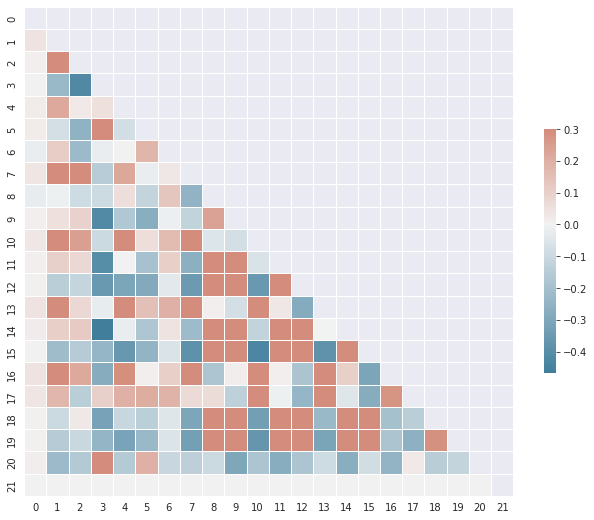

In [229]:
# Scale data to zero mean unit variance to make patterns more visible
scaler = StandardScaler()
valid_df_scaled = scaler.fit_transform(valid_df)
_pca = PCA()
_pca.fit(valid_df_scaled)

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = _pca.get_covariance()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
# WARNING: vmax reduces actual contrast to make structures more visible, remove to get a numerically accurate heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})
